<a href="https://colab.research.google.com/github/BoboSamson/BoboSamson/blob/main/lab4_samson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install torchinfo

In [34]:
import torch
import torchvision

In [35]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary

In [36]:
#Set up device agnostics
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
#Get Data
import os
import zipfile

from pathlib import Path

import requests

In [38]:
#Set up the data path
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

#If the image folder doesn't exist, download it and prepare it....
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

				#Download pizza, steak,sushi data
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data.....")
        f.write(request.content)

								#Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data....")
        zip_ref.extractall(image_path)

								#Remove zip file
    os.remove(data_path/"pizza_steak_susshi.zip")


data/pizza_steak_sushi directory exists.


In [39]:
#Set up Dirs
train_dir = image_path/ "train"
test_dir = image_path/ "test"


In [40]:
#Get a set of pretarined model weigths
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
weights

EfficientNet_B2_Weights.IMAGENET1K_V1

In [41]:
#Creat traning and testing dataloaders
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
        train_dir: str,
        test_dir:str,
        transform: transforms.Compose,
        batch_size:int,
        num_workers: int=NUM_WORKERS
):

#Use Image folder to create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

#Get class names
    class_names = train_data.classes

#Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory = True,
)
    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
)
    return train_dataloader, test_dataloader, class_names


In [42]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [43]:
#Creating training and testing Dataloaders as well s get list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d2aa4b63e10>,
 ['pizza', 'steak', 'sushi'])

In [44]:
#Getting a pretarined model
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model = torchvision.models.efficientnet_b2(weights=weights).to(device)

In [45]:
#Print a summary using torchinfo
summary(model=model,
        input_size= (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [46]:
#Freez the base model and change the output layer
for param in model.features.parameters():
    param.requires_grad = False


In [47]:
#Set the manual seeds
torch.manual_seed(44)
torch.cuda.manual_seed(44)

#Get the length of class_names (one output for each class)
output_shape = len(class_names)

#Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)).to(device)


In [48]:
#Do a summary after freezing the features and changing the output classifier layer
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [49]:
#Define loss and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
# Train Model
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward Pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric scores across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in evaluation mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc  # <-- Missing return statement fixed


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # Make sure model is on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results  # <-- Indentation fixed


In [51]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1214 | train_acc: 0.3672 | test_loss: 1.0011 | test_acc: 0.5066
Epoch: 2 | train_loss: 0.8831 | train_acc: 0.7812 | test_loss: 0.9091 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.7928 | train_acc: 0.7734 | test_loss: 0.8249 | test_acc: 0.7642
Epoch: 4 | train_loss: 0.7462 | train_acc: 0.7500 | test_loss: 0.7236 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.6781 | train_acc: 0.8008 | test_loss: 0.7038 | test_acc: 0.8665
[INFO] Total training time: 17.631 seconds


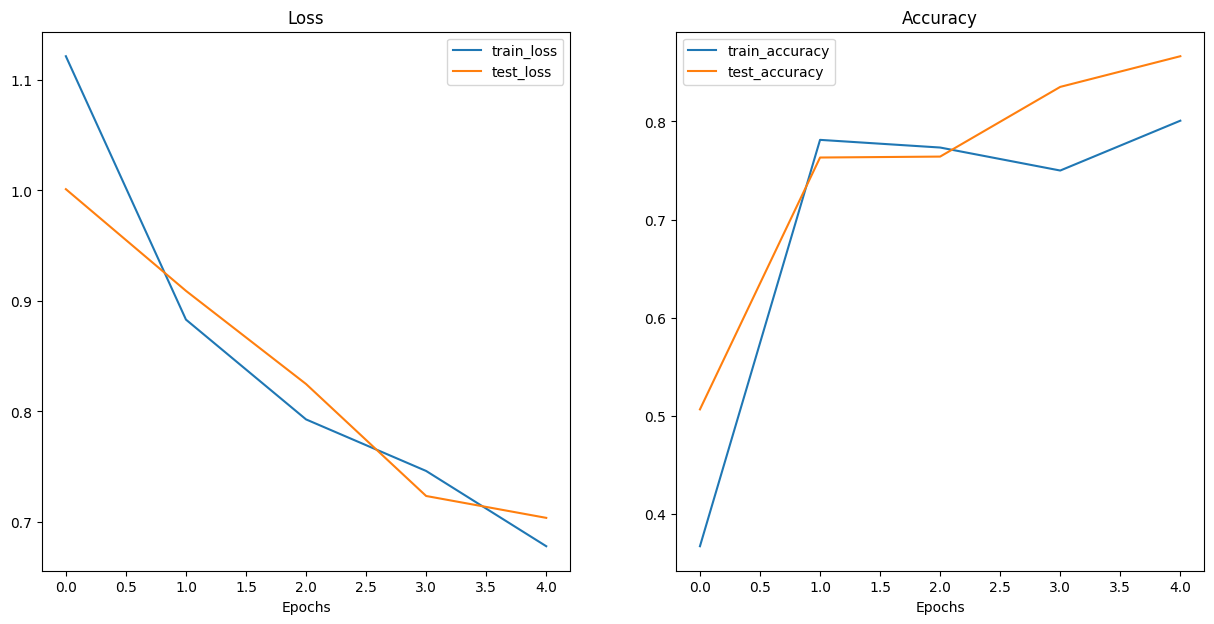

In [52]:
#Evaluate model by plottting loss curves

loss = results["train_loss"]
test_loss = results["test_loss"]

accuracy = results["train_acc"]
test_accuracy = results["test_acc"]

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label="train_accuracy")
plt.plot(epochs, test_accuracy, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [53]:
"""The visualisations show that the trained model is avoiding overfitting . Train and test accuracy are increasing as the number of epochs increase"""

'The visualisations show that the trained model is avoiding overfitting . Train and test accuracy are increasing as the number of epochs increase'

In [54]:
#Make predictions on images from the test set

from typing import List, Tuple

from PIL import Image

#Take in a trained model, class name, image path, image size, a transform and  target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  #Open image
# 2. Open image
    img = Image.open(image_path)


    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize(image_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[2.229, 0.224, 0.225]),])

    #Predict on an image and make sure the model is on the target device

    model.to(device)
    #Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)

    #Make prediciton on image with an extra dimension
    target_image_pred = model(transformed_image.to(device))

 #Covert logits -> prediction probabilities (using torch.softmax)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    #Convert prediction probabilities -> prediction labels
#Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

#Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)




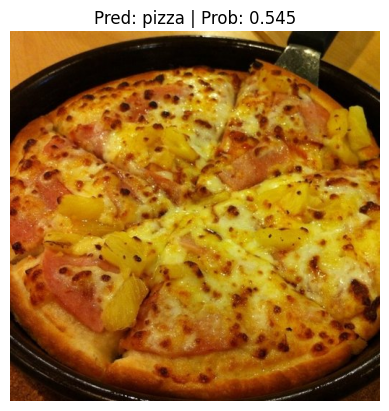

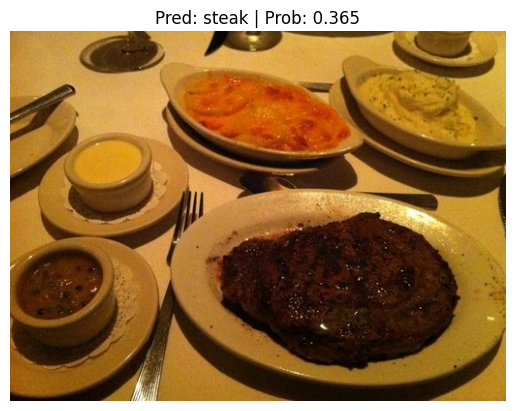

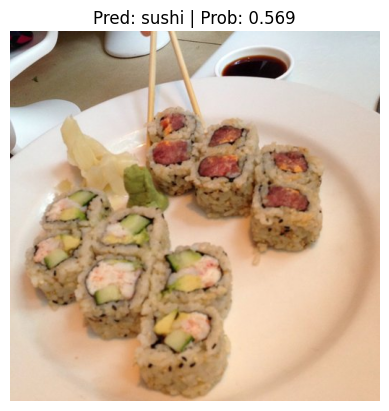

In [55]:
#MAke predicitons on random images
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224))

data/NYPICHPDPICT000053299815.jpg already exists, skipping download.


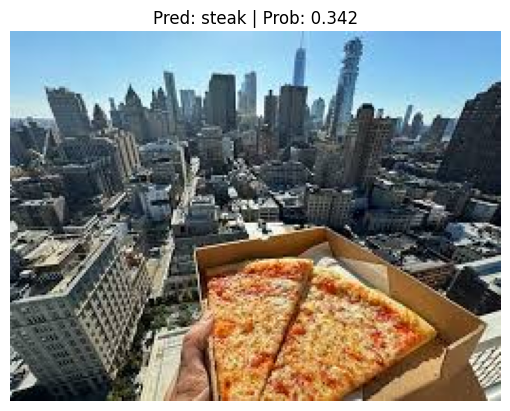

In [56]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "NYPICHPDPICT000053299815.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSgDyyEUI6qaPZxplyarcZ0asCKo6aaUlStXQ&s")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

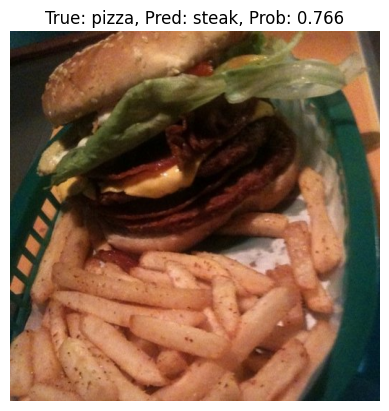

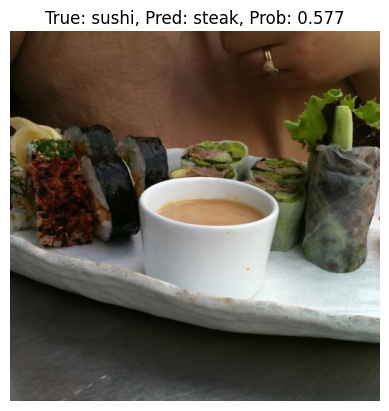

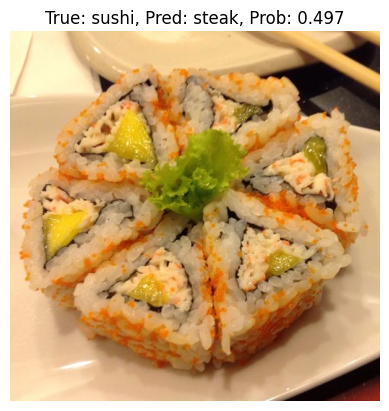

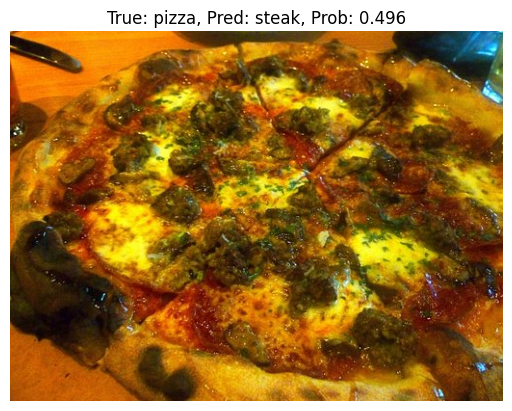

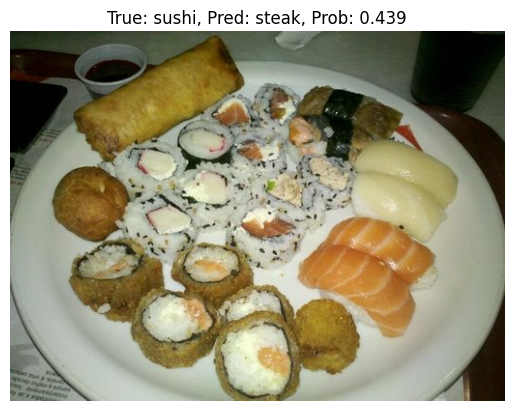

In [57]:
import torch
from typing import List, Tuple, Dict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict_all_images(model: torch.nn.Module,
                      dataloader: torch.utils.data.DataLoader,
                      class_names: List[str],
                      device: torch.device = device) -> Dict[str, np.ndarray]:
    """Predicts labels and probabilities for all images in the dataloader.

    Args:
        model: The trained PyTorch model.
        dataloader: The DataLoader containing the test dataset.
        class_names: A list of class names.
        device: The device to run the model on.

    Returns:
        A dictionary containing the image paths, true labels, predicted labels,
        and predicted probabilities.
    """
    model.eval()
    with torch.inference_mode():
        all_image_paths = []
        all_true_labels = []
        all_pred_labels = []
        all_pred_probs = []

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred_logits = model(X)
            pred_probs = torch.softmax(pred_logits, dim=1)
            pred_labels = torch.argmax(pred_probs, dim=1)

            # Get image paths for this batch
            image_paths = [dataloader.dataset.samples[i][0]
                           for i in range(batch * dataloader.batch_size,
                                          min((batch + 1) * dataloader.batch_size,
                                              len(dataloader.dataset)))]

            all_image_paths.extend(image_paths)
            all_true_labels.extend(y.cpu().numpy())
            all_pred_labels.extend(pred_labels.cpu().numpy())
            all_pred_probs.extend(pred_probs.cpu().numpy())

    return {
        "image_paths": np.array(all_image_paths),
        "true_labels": np.array(all_true_labels),
        "pred_labels": np.array(all_pred_labels),
        "pred_probs": np.array(all_pred_probs)
    }

def plot_most_wrong_images(predictions: Dict[str, np.ndarray],
                           class_names: List[str],
                           num_images: int = 5):
    """Plots the most wrong predictions.

    Args:
        predictions: A dictionary containing the predictions.
        class_names: A list of class names.
        num_images: The number of images to plot.
    """
    # Find incorrect predictions
    incorrect_indices = np.where(predictions["true_labels"] != predictions["pred_labels"])[0]

    # Sort incorrect predictions by descending predicted probability
    sorted_indices = incorrect_indices[np.argsort(
        -predictions["pred_probs"][incorrect_indices, predictions["pred_labels"][incorrect_indices]])]

    # Plot the most wrong images
    for i in range(min(num_images, len(sorted_indices))):
        index = sorted_indices[i]
        image_path = predictions["image_paths"][index]
        true_label = class_names[predictions["true_labels"][index]]
        pred_label = class_names[predictions["pred_labels"][index]]
        pred_prob = predictions["pred_probs"][index, predictions["pred_labels"][index]]

        img = Image.open(image_path)
        plt.figure()
        plt.imshow(img)
        plt.title(f"True: {true_label}, Pred: {pred_label}, Prob: {pred_prob:.3f}")
        plt.axis(False)
        plt.show()

# Get predictions for all images in the test dataset
predictions = predict_all_images(model, test_dataloader, class_names)

# Plot the 5 most wrong images
plot_most_wrong_images(predictions, class_names, num_images=5)

In [58]:
!pip install scikit-learn

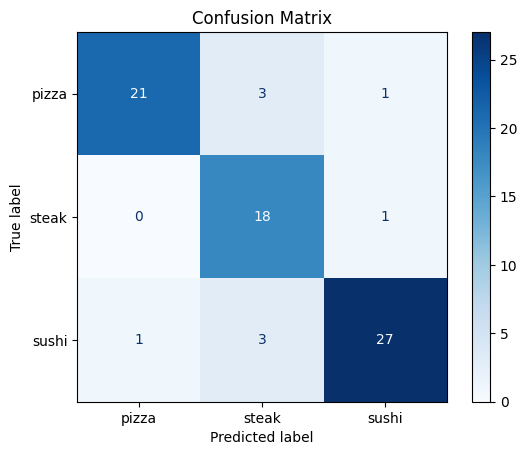

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(predictions: Dict[str, np.ndarray],
                           class_names: List[str]):
    """Plots a confusion matrix.

    Args:
        predictions: A dictionary containing the predictions.
        class_names: A list of class names.
    """
    # Get true labels and predicted labels
    true_labels = predictions["true_labels"]
    pred_labels = predictions["pred_labels"]

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if you like
    plt.title("Confusion Matrix")
    plt.show()

# Call the function after getting predictions
predictions = predict_all_images(model, test_dataloader, class_names)
plot_confusion_matrix(predictions, class_names)